In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import mrnn

## Using quadratic tensor forms to solve problems

Such as XOR.

First, what is even the problem?

C = A XOR B has truth table

| A | B | C |
|---|---|---|
| T | T | F |
| T | F | T |
| F | T | T |
| F | F | F |

which, if we assign numeric values, is not linearly separable.

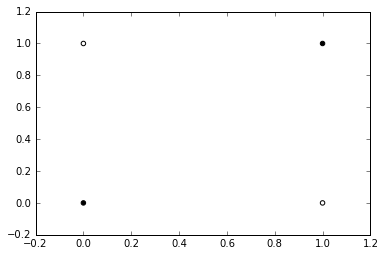

In [2]:
xor_inputs = np.array([[1., 1.],
                       [1., 0.],
                       [0., 1.],
                       [0., 0.]])
xor_targets = np.array([0., 1., 1., 0.])

plt.scatter(xor_inputs[:,0], xor_inputs[:,1], 
            c=[str(val) for val in xor_targets],
            cmap='gray')

With a normal feedforward net, we can't learn this. We can if we incorporate some amount of pairwise information.

In [3]:
def affine(input_var, new_size, name='affine'):
    """get weights and bias, return transformed variable"""
    with tf.variable_scope(name):
        old_size = input_var.get_shape()[1].value
        weights = tf.get_variable('weights', shape=[old_size, new_size])
        bias = tf.get_variable('bias', shape=[new_size])
        return tf.nn.bias_add(tf.matmul(input_var, weights), bias)

def quadratic(input_var, output_size, rank, name='tensor'):
    """Get tensor and biases etc."""
    with tf.variable_scope(name):
        input_size = input_var.get_shape()[1].value
        tensor = mrnn.get_cp_tensor([input_size, output_size, input_size],
                                    rank, 'tensor_weights')
        weights = tf.get_variable('weights', shape=[input_size, output_size])
        bias = tf.get_variable('bias', shape=[output_size])

        result = mrnn.bilinear_product_cp(input_var, tensor, input_var)


        return result + tf.matmul(input_var, weights) + bias

def get_loss(net_out, target):
    return tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(net_out, target))

def get_train_op(loss, learning_rate):
    return tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [9]:
tf.reset_default_graph()

input_var = tf.constant(xor_inputs, dtype=tf.float32)
target_var = tf.constant(xor_targets, dtype=tf.float32)

with tf.variable_scope('classic'):
    classic_out = affine(input_var, 1, 'input')
    classic_out = tf.squeeze(classic_out)
with tf.variable_scope('mlp'):
    mlp_out = affine(tf.nn.sigmoid(affine(input_var, 4, 'input')), 1, 'output')
    mlp_out = tf.squeeze(mlp_out)
with tf.variable_scope('tensor'):
    tensor_out = quadratic(input_var, 1, 1, 'input')
    tensor_out = tf.squeeze(tensor_out)

classic_loss = get_loss(classic_out, target_var)
mlp_loss = get_loss(mlp_out, target_var)
tensor_loss = get_loss(tensor_out, target_var)

classic_train = get_train_op(classic_loss, 0.5)
mlp_train = get_train_op(mlp_loss, 0.5)
tensor_train = get_train_op(tensor_loss, 0.5)
train_op = tf.group(classic_train, mlp_train, tensor_train)

runs = []

In [22]:
NUM_EPOCHS = 1000

for run in range(50):
    losses = {'perceptron': [], 
              'mlp': [], 
              'tensor': []}

    sess = tf.Session()
    sess.run(tf.initialize_all_variables())
    print('\nRun {}'.format(run))
    for i in range(NUM_EPOCHS):
        c_loss, m_loss, t_loss, _ = sess.run([classic_loss,
                                      mlp_loss,
                                      tensor_loss,
                                      train_op])
        if (i+1) % 10 == 0:
            print('\rclassic: {}, mlp: {}, tensor: {}'.format(c_loss, m_loss, t_loss), end='')
        losses['perceptron'].append(c_loss)
        losses['mlp'].append(m_loss)
        losses['tensor'].append(t_loss)
    runs.append(losses)


Run 0
classic: 0.6931471824645996, mlp: 0.04282071813941002, tensor: 0.0021924597676843405
Run 1
classic: 0.6931471824645996, mlp: 0.05011961609125137, tensor: 0.0025280872359871864
Run 2
classic: 0.6931471824645996, mlp: 0.029187675565481186, tensor: 0.002347770845517516
Run 3
classic: 0.6931471824645996, mlp: 0.042603492736816406, tensor: 0.002275984501466155
Run 4
classic: 0.6931471824645996, mlp: 0.04767608642578125, tensor: 0.0023214465472847223
Run 5
classic: 0.6931471824645996, mlp: 0.0986846312880516, tensor: 0.002700681798160076
Run 6
classic: 0.6931471824645996, mlp: 0.2009737640619278, tensor: 0.0022695709485560656
Run 7
classic: 0.6931471824645996, mlp: 0.08484002202749252, tensor: 0.0022368323989212513
Run 8
classic: 0.6931471824645996, mlp: 0.03029170259833336, tensor: 0.002233280334621668
Run 9
classic: 0.6931471824645996, mlp: 0.0546279214322567, tensor: 0.0021892462391406298
Run 10
classic: 0.6931471824645996, mlp: 0.07682646065950394, tensor: 0.0022726531606167555
Ru

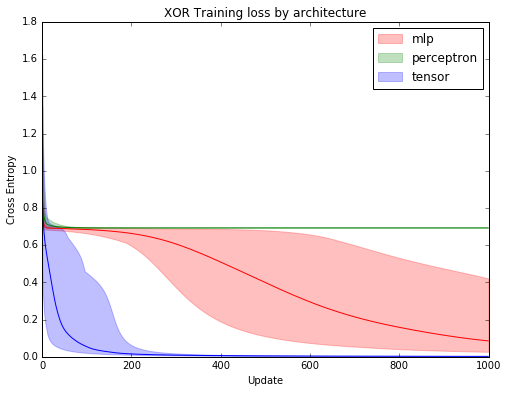

In [26]:
def plot_min_max(data, key, color='b'):
    x = np.arange(len(data[0][key]))
    np_data = np.array([run[key] for run in data])
    
    plt.fill_between(x, np_data.min(axis=0), np_data.max(axis=0), alpha=0.25, label=key, color=color)
    plt.plot(x, np_data.mean(axis=0), color=color)


# x = np.arange(len(runs['0'][0]))
# plt.fill_between(x, runs['0'][1], runs['3'][1], alpha=0.5)
# plt.plot(x, runs['0'][0])
# plt.plot(x, runs['0'][2])
plt.figure(figsize=(8,6))
plot_min_max(runs, 'mlp', 'r')
plot_min_max(runs, 'perceptron', 'g')
plot_min_max(runs, 'tensor', 'b')
plt.legend()
plt.title('XOR Training loss by architecture')
plt.xlabel('Update')
plt.ylabel('Cross Entropy')

It might be nice to have a look at the decision boundaries, to see how the tensor guy is nonlinear.

We will do this just by sampling a fairly dense grid and pushing it through all the models.

We also want more of a conceptual XOR, some kind of occasion where we want to be able to tell if pairs of features occur with a similar "one or the other but not both" structure. 